# Seminární práce II – KI/PZS (VOICED)
## Klasifikace hlasových záznamů (normální vs. patologický + typ patologie)



In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import re
import wfdb

from scipy.signal import get_window
from scipy.fft import rfft, rfftfreq
from scipy.fftpack import dct
from scipy.stats import skew, kurtosis

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, confusion_matrix
)
np.random.seed(42)


## 1) Nastavení cesty k databázi VOICED



In [17]:
BASE_DIR = Path(r"F:/PZS/data/")
VOICED_DIR = BASE_DIR /"voicedb"/"voice-icar-federico-ii-database-1.0.0" 

In [20]:
# každý záznam má .hea soubor -> jako index
records = sorted([p.with_suffix("") for p in VOICED_DIR.rglob("*.hea")])

## 2) Načtení anotací (diagnóza) z hlaviček
V hlavičce (header) je textový popis. 

Z něj vytáhnout:
- binární štítek: **normal** vs. **pathological**
- třídu patologie (pokud není normal)



In [21]:
def parse_labels_from_header(hdr) -> tuple[str, str]:
    """Vrátí (binary_label, pathology_label). pathology_label je např. 'normal' nebo konkrétní diagnóza."""
    comments = getattr(hdr, "comments", None) or []
    blob = " | ".join(comments)
    blob_u = blob.upper()

    # Heuristiky pro normal/healthy
    is_normal = ("NORMAL" in blob_u) or ("HEALTH" in blob_u) or ("HEALTHY" in blob_u)
    # Heuristiky pro patologii
    is_path = ("PATH" in blob_u) or ("DISORDER" in blob_u) or ("DYS" in blob_u) or ("NOD" in blob_u) or ("POLYP" in blob_u)

    binary = "normal" if is_normal and not is_path else "pathological"

    # Diagnóza: zkus najít řádek/segment s klíčovým slovem
    diag = None
    patterns = [
        r"(<DIAGNOSES>\s*:\s*)([^|]+)",
        r"(DIAGNOSIS\s*:\s*)([^|]+)",
        r"(DIAG\s*:\s*)([^|]+)",
        r"(PATHOLOGY\s*:\s*)([^|]+)",
        r"(DISORDER\s*:\s*)([^|]+)",
    ]
    for pat in patterns:
        m = re.search(pat, blob_u)
        if m:
            diag = m.group(2).strip()
            break

    if binary == "normal":
        return binary, "normal"

    # Pokud diagnózu nenašli, zkusíme odvodit z blobu podle známých termů
    if diag is None:
        # Zjednodušeně: vezmi pár klíčových slov, která se často vyskytují
        known = ["NODULE", "NODULES", "POLYP", "POLYPS", "CYST", "CYSTS", "PARESIS", "PARALYSIS", "REINKE", "EDEMA",
                 "HYPERFUNCTION", "HYPOFUNCTION", "DYSPHONIA", "LARYNGITIS", "CANCER", "TUMOR"]
        for k in known:
            if k in blob_u:
                diag = k
                break
    if diag is None:
        diag = "unknown_pathology"

    # Normalizace názvů
    diag = diag.replace("  ", " ").strip().title()
    return binary, diag


# Otestuj parser na pár recordech
rows = []
for rp in records[:10]:
    hdr = wfdb.rdheader(str(rp))
    b, d = parse_labels_from_header(hdr)
    rows.append({"záznam": rp.name, "třída": b, "diagnoza": d, "poznámky": (hdr.comments or [""])[0][:80]})
pd.DataFrame(rows)


,záznam,třída,diagnoza,poznámky
0,voice001,pathological,Hyperkinetic Dysphonia <Medications>: None,<age>: 32 <sex>: M <diagnoses>: hyperkinetic ...
1,voice002,normal,normal,<age>: 55 <sex>: M <diagnoses>: healthy <medi...
2,voice003,pathological,Hyperkinetic Dysphonia <Medications>: None,<age>: 34 <sex>: M <diagnoses>: hyperkinetic ...
3,voice004,pathological,Hypokinetic Dysphonia <Medications>: None,<age>: 28 <sex>: F <diagnoses>: hypokinetic d...
4,voice005,pathological,Hypokinetic Dysphonia <Medications>: None,<age>: 54 <sex>: F <diagnoses>: hypokinetic d...
5,voice006,pathological,Hyperkinetic Dysphonia <Medications>: None,<age>: 41 <sex>: M <diagnoses>: hyperkinetic ...
6,voice007,pathological,Hyperkinetic Dysphonia <Medications>: None,<age>: 41 <sex>: M <diagnoses>: hyperkinetic ...
7,voice008,pathological,Reflux Laryngitis <Medications>: None,<age>: 51 <sex>: F <diagnoses>: reflux laryng...
8,voice009,pathological,Hyperkinetic Dysphonia <Medications>: None,<age>: 53 <sex>: F <diagnoses>: hyperkinetic ...
9,voice010,pathological,Hypokinetic Dysphonia <Medications>: None,<age>: 47 <sex>: F <diagnoses>: hypokinetic d...


In [22]:
labels = []
for rp in records:
    hdr = wfdb.rdheader(str(rp))
    b, d = parse_labels_from_header(hdr)
    labels.append((b, d))

s = pd.DataFrame(labels, columns=["třída", "diagnóza"])
print("Počty binárních tříd:\n", s["třída"].value_counts())
print("\nNejčastější diagnózy:\n", s["diagnóza"].value_counts().head(15))
print("\nNeznámá diagnóza::", (s["diagnóza"]=="Neznámá diagnóza:").sum())

Počty binárních tříd:
 třída
pathological    151
normal           57
Name: count, dtype: int64

Nejčastější diagnózy:
 diagnóza
Hyperkinetic Dysphonia <Medications>: None    72
normal                                        57
Hypokinetic Dysphonia <Medications>: None     40
Reflux Laryngitis <Medications>: None         38
Hyperkineti Dysphonia <Medications>: None      1
Name: count, dtype: int64

Neznámá diagnóza:: 0


## 3) Načtení audio signálu
Z VOICED beru záznamy hlásky **"a"**. Získáme 1D signál a vzorkovací frekvenci `fs`.


In [23]:
def load_voiced_signal(record_path: Path):
    rec = wfdb.rdrecord(str(record_path))
    fs = float(rec.fs)
    x = rec.p_signal
    # typicky 1 kanál; pokud více, vezmi první
    if x.ndim == 2:
        x = x[:, 0]
    x = np.asarray(x, dtype=float)
    # DC odstranění a normalizace
    x = x - np.mean(x)
    mx = np.max(np.abs(x)) + 1e-12
    x = x / mx
    return x, fs

# ukázka načtení
if len(records) > 0:
    x0, fs0 = load_voiced_signal(records[0])
    print("fs:", fs0, "len:", len(x0), "duration[s]:", len(x0)/fs0)


fs: 8000.0 len: 38080 duration[s]: 4.76


## 4) Příznaky (features)
Kombinaci:
- **časová oblast**: RMS, ZCR, šikmost, špičatost, energie
- **frekvenční oblast (FFT)**: centroid, bandwidth, rolloff, flatness
- **kepstrum / MFCC**: 13 MFCC koeficientů (průměr + směrodatná odchylka)




In [24]:
# Rámování signálu
def frame_signal(x, fs, frame_ms=25, hop_ms=10, window="hann"):
    x = np.asarray(x, dtype=float)

    frame_len = int(round(frame_ms / 1000 * fs))
    hop = int(round(hop_ms / 1000 * fs))

    if frame_len < 4 or hop < 1:
        raise ValueError("Frame/hop příliš malé.")
    if len(x) < frame_len:
        # aspoň 1 frame
        x = np.pad(x, (0, frame_len - len(x)), mode="constant")

    n_frames = 1 + max(0, (len(x) - frame_len) // hop)
    frames = np.zeros((n_frames, frame_len), dtype=float)

    w = get_window(window, frame_len, fftbins=True).astype(float)

    for i in range(n_frames):
        start = i * hop
        seg = x[start:start + frame_len]
        if len(seg) < frame_len:
            seg = np.pad(seg, (0, frame_len - len(seg)), mode="constant")
        frames[i] = seg * w

    return frames, frame_len, hop

# Časové příznaky
def _zcr_robust(frame):
    s = np.sign(frame)
    s[s == 0] = 1  # nuly nedělají falešné přechody
    return 0.5 * np.mean(np.abs(np.diff(s)))

def time_features(frames):
    frames = np.asarray(frames, dtype=float)

    rms = np.sqrt(np.mean(frames**2, axis=1) + 1e-12)
    zcr = np.array([_zcr_robust(f) for f in frames], dtype=float)

    # skew/kurtosis per-frame
    sk = np.array([skew(f, bias=False) for f in frames], dtype=float)
    ku = np.array([kurtosis(f, fisher=True, bias=False) for f in frames], dtype=float)

    feats = np.array([
        np.mean(rms), np.std(rms),
        np.mean(zcr), np.std(zcr),
        np.mean(sk),  np.std(sk),
        np.mean(ku),  np.std(ku),
    ], dtype=float)

    return feats

# Spektrální příznaky (z power spektra)
def spectral_features(frames, fs):
    frames = np.asarray(frames, dtype=float)
    n_fft = frames.shape[1]

    # POWER spectrum
    pow_spec = (np.abs(rfft(frames, axis=1))**2) + 1e-12
    freqs = rfftfreq(n_fft, d=1/fs)

    # normalizace na "pravděpodobnostní" rozdělení energie
    p = pow_spec / np.sum(pow_spec, axis=1, keepdims=True)

    centroid = np.sum(freqs * p, axis=1)
    bandwidth = np.sqrt(np.sum(((freqs - centroid[:, None])**2) * p, axis=1))

    # rolloff 85 %
    cumsum = np.cumsum(p, axis=1)
    rolloff_idx = np.argmax(cumsum >= 0.85, axis=1)
    rolloff = freqs[rolloff_idx]

    # flatness – může být z magnitudy nebo power, tady z power:
    flatness = np.exp(np.mean(np.log(pow_spec), axis=1)) / np.mean(pow_spec, axis=1)

    feats = np.array([
        np.mean(centroid), np.std(centroid),
        np.mean(bandwidth), np.std(bandwidth),
        np.mean(rolloff), np.std(rolloff),
        np.mean(flatness), np.std(flatness),
    ], dtype=float)

    return feats

# MFCC pomocné funkce
def hz_to_mel(hz):
    return 2595.0 * np.log10(1.0 + hz / 700.0)

def mel_to_hz(mel):
    return 700.0 * (10**(mel / 2595.0) - 1.0)

def mel_filterbank(n_fft, fs, n_mels=26, fmin=0.0, fmax=None):
    if fmax is None:
        fmax = fs / 2

    m_min = hz_to_mel(fmin)
    m_max = hz_to_mel(fmax)
    m_pts = np.linspace(m_min, m_max, n_mels + 2)
    hz_pts = mel_to_hz(m_pts)

    bins = np.floor((n_fft + 1) * hz_pts / fs).astype(int)

    fb = np.zeros((n_mels, n_fft // 2 + 1), dtype=float)
    for m in range(1, n_mels + 1):
        f_left, f_center, f_right = bins[m - 1], bins[m], bins[m + 1]
        if f_right <= f_left:
            continue

        for k in range(f_left, f_center):
            if 0 <= k < fb.shape[1] and f_center > f_left:
                fb[m - 1, k] = (k - f_left) / (f_center - f_left + 1e-12)

        for k in range(f_center, f_right):
            if 0 <= k < fb.shape[1] and f_right > f_center:
                fb[m - 1, k] = (f_right - k) / (f_right - f_center + 1e-12)

    return fb

# MFCC (n_fft jako mocnina 2)
def mfcc_features(frames, fs, n_mels=26, n_mfcc=13, fmin=50.0, fmax=None):
    frames = np.asarray(frames, dtype=float)
    frame_len = frames.shape[1]

    # nejbližší vyšší mocnina 2
    n_fft = int(2**np.ceil(np.log2(frame_len)))
    if fmax is None:
        fmax = fs / 2

    # power spectrum s n_fft
    pow_spec = (np.abs(rfft(frames, n=n_fft, axis=1))**2) + 1e-12

    fb = mel_filterbank(n_fft, fs, n_mels=n_mels, fmin=fmin, fmax=fmax)
    mel_energy = np.dot(pow_spec, fb.T) + 1e-12
    log_mel = np.log(mel_energy)

    ceps = dct(log_mel, type=2, axis=1, norm="ortho")[:, :n_mfcc]

    feats = np.concatenate([np.mean(ceps, axis=0), np.std(ceps, axis=0)]).astype(float)
    return feats

# Celková extrakce
def extract_features(x, fs):
    frames, _, _ = frame_signal(x, fs, frame_ms=25, hop_ms=10, window="hann")
    tf = time_features(frames)
    sf = spectral_features(frames, fs)
    cf = mfcc_features(frames, fs, n_mels=26, n_mfcc=13)
    return np.concatenate([tf, sf, cf]).astype(float)

# Test na 1 záznamu
if len(records) > 0:
    x, fs = load_voiced_signal(records[0])
    feat = extract_features(x, fs)
    print("Feature dim:", feat.shape, "first 10:", feat[:10])


Feature dim: (42,) first 10: [1.33086159e-01 2.34159685e-02 2.35396391e-01 4.05062616e-02
 1.66203259e+00 5.09333329e-01 9.86476613e+00 3.26074778e+00
 8.88316839e+02 1.36613524e+02]


## 5) Sestavení datasetu (X, y)
- `y_bin`: normal / pathological
- `y_multi`: normal + konkrétní diagnóza



In [25]:
# Sestavení datasetu (X, y)
data = []

for rp in records:
    try:
        hdr = wfdb.rdheader(str(rp))
        yb, ym = parse_labels_from_header(hdr)

        x, fs = load_voiced_signal(rp)
        feat = extract_features(x, fs)

        data.append({
            "record": rp.name,
            "fs": fs,
            "y_bin": yb,
            "y_multi": ym,
            "feat": feat,
            "error": None
        })

    except Exception as e:
        data.append({
            "record": rp.name,
            "error": str(e)
        })

# Vytvoření DataFrame ze sesbíraných dat
df = pd.DataFrame(data)

# Pro jistotu zajistíme existenci sloupce "error"
if "error" not in df.columns:
    df["error"] = None

# Základní kontrola
print(
    "Celkem:", len(df),
    "OK:", df["error"].isna().sum(),
    "Error:", df["error"].notna().sum()
)

# Vybere pouze korektní záznamy (bez chyb)
df_ok = df[df["error"].isna()].copy()

print("Použito pro učení:", len(df_ok))

# Feature matice X
# každý řádek obsahuje 42D vektor příznaků
X = np.vstack(df_ok["feat"].values)

print("X shape:", X.shape)   # očekáváno (N, 42)

# Binární cílová proměnná
#   y_bin ∈ {normal, pathological}
y_bin = df_ok["y_bin"].astype(str).values

print("\nBinární labely:")
print(pd.Series(y_bin).value_counts())

# Vícetřídní cílová proměnná
#   y_multi = normal + konkrétní diagnóza
#   (sjednotíme různé zápisy diagnóz)

def simplify_pathology(p: str) -> str:
    if p is None:
        return "other"

    s = str(p).lower()

    if "normal" in s or "healthy" in s:
        return "normal"

    if "hyper" in s and "dysphon" in s:
        return "hyperkinetic_dysphonia"

    if "hypo" in s and "dysphon" in s:
        return "hypokinetic_dysphonia"

    if "dysphon" in s:
        return "dysphonia"

    if "laryng" in s or "reflux" in s:
        return "laryngitis"

    return "other"


y_multi = df_ok["y_multi"].astype(str).apply(simplify_pathology).values

print("\nVíce-třídní labely:")
print(pd.Series(y_multi).value_counts())

# Shrnutí
print("\nShrnutí datasetu:")
print("Počet vzorků:", X.shape[0])
print("Počet příznaků:", X.shape[1])
print("Binární třídy:", np.unique(y_bin))
print("Multi třídy:", np.unique(y_multi))


Celkem: 208 OK: 208 Error: 0
Použito pro učení: 208
X shape: (208, 42)

Binární labely:
pathological    151
normal           57
Name: count, dtype: int64

Více-třídní labely:
hyperkinetic_dysphonia    73
normal                    57
hypokinetic_dysphonia     40
laryngitis                38
Name: count, dtype: int64

Shrnutí datasetu:
Počet vzorků: 208
Počet příznaků: 42
Binární třídy: ['normal' 'pathological']
Multi třídy: ['hyperkinetic_dysphonia' 'hypokinetic_dysphonia' 'laryngitis' 'normal']


## 6) Vizualizace signálu (časová oblast, FFT, kepstrum)
Jeden normal a jeden pathological záznam (pokud jsou dostupné) a ukážu:
- časový průběh
- spektrum (FFT)
- reálné kepstrum (ukázka)


Normal example: voice002
Path example: voice001


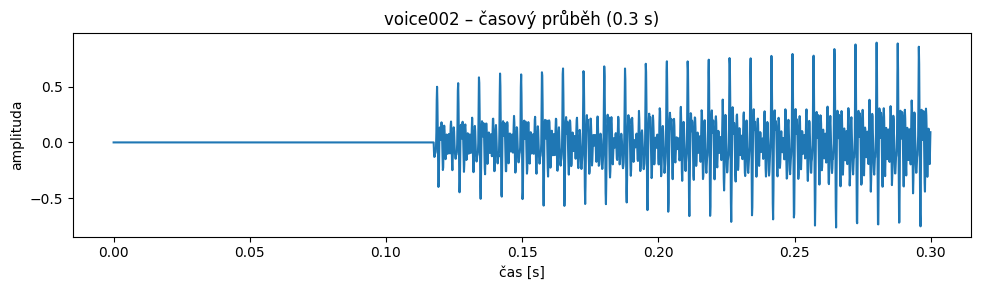

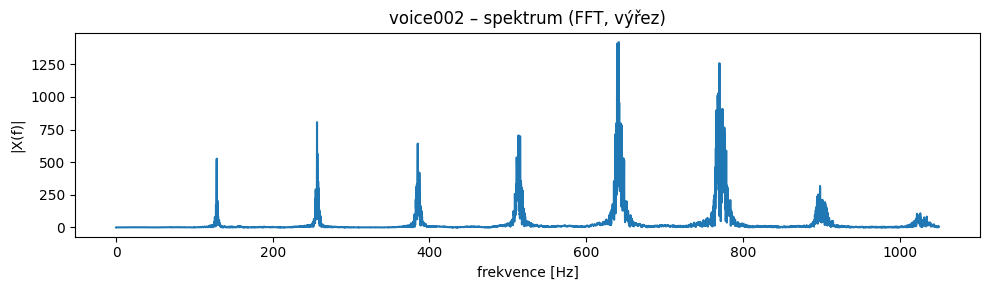

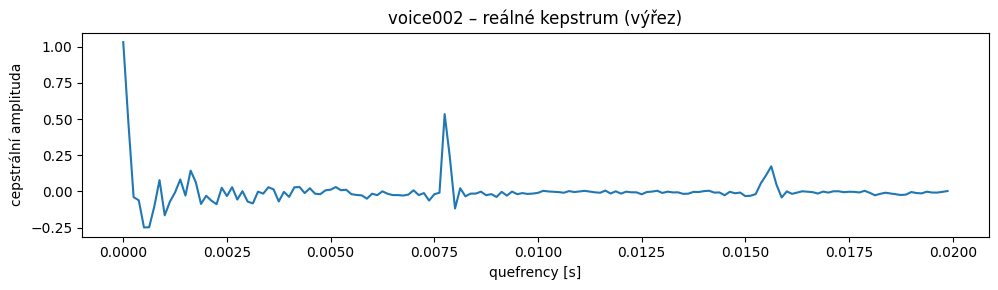

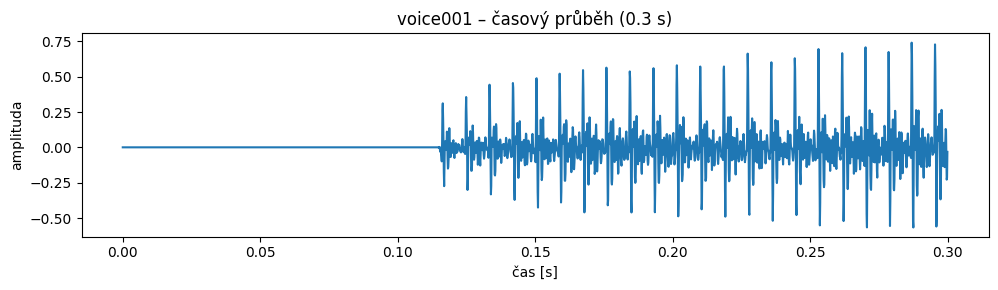

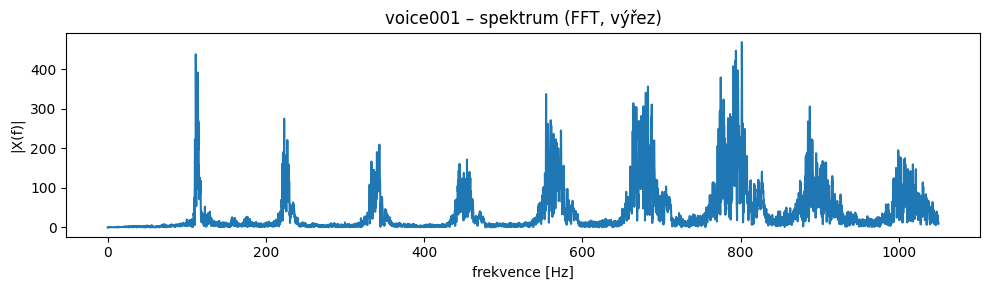

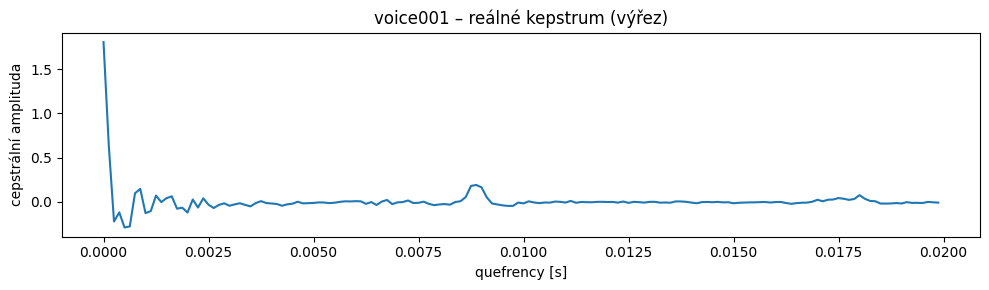

In [26]:

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

def plot_example(record_name, prefix):
    rp = VOICED_DIR / record_name
    x, fs = load_voiced_signal(rp)
    t = np.arange(len(x))/fs

    # FFT
    N = len(x)
    Xf = np.abs(rfft(x))
    f = rfftfreq(N, d=1/fs)

    # reálné kepstrum (log spektrum -> irfft)
    log_spec = np.log(np.abs(rfft(x)) + 1e-12)
    ceps = np.fft.irfft(log_spec)
    q = np.arange(len(ceps))/fs  # quefrency ~ sekundy

    plt.figure(figsize=(10,3))
    plt.plot(t[:int(fs*0.3)], x[:int(fs*0.3)])
    plt.title(f"{record_name} – časový průběh (0.3 s)")
    plt.xlabel("čas [s]"); plt.ylabel("amplituda")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{prefix}_time.png", dpi=200, bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(10,3))
    plt.plot(f[:5000], Xf[:5000])
    plt.title(f"{record_name} – spektrum (FFT, výřez)")
    plt.xlabel("frekvence [Hz]"); plt.ylabel("|X(f)|")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{prefix}_fft.png", dpi=200, bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(10,3))
    plt.plot(q[:int(fs*0.02)], ceps[:int(fs*0.02)])
    plt.title(f"{record_name} – reálné kepstrum (výřez)")
    plt.xlabel("quefrency [s]"); plt.ylabel("cepstrální amplituda")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{prefix}_cepstrum.png", dpi=200, bbox_inches="tight")
    plt.show()

# Najdi příklad normal a pathological
rec_normal = df_ok[df_ok["y_bin"]=="normal"]["record"].iloc[0] if (df_ok["y_bin"]=="normal").any() else None
rec_path = df_ok[df_ok["y_bin"]=="pathological"]["record"].iloc[0] if (df_ok["y_bin"]=="pathological").any() else None
print("Normal example:", rec_normal)
print("Path example:", rec_path)

if rec_normal: plot_example(rec_normal, "fig1_normal")
if rec_path: plot_example(rec_path, "fig1_pathological")


## 7) Klasifikace: normal vs. pathological (binární)
Použijeme dvě metody:
- kNN (k=5)
- SVM (RBF)

Výstup: přesnost, balanced accuracy, F1, konfuzní matice.


In [27]:
def evaluate_binary(X, y, model, test_size=0.25):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)

    acc = accuracy_score(yte, pred)
    bacc = balanced_accuracy_score(yte, pred)
    f1 = f1_score(yte, pred, average="binary", pos_label="pathological")
    cm = confusion_matrix(yte, pred, labels=["normal","pathological"])

    return {"acc": acc, "bacc": bacc, "f1": f1, "cm": cm, "yte": yte, "pred": pred}

knn_bin = Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(n_neighbors=5))])
svm_bin = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", C=10.0, gamma="scale"))])

res_knn = evaluate_binary(X, y_bin, knn_bin)
res_svm = evaluate_binary(X, y_bin, svm_bin)

pd.DataFrame([
    {"model":"kNN (k=5)", **{k:res_knn[k] for k in ["acc","bacc","f1"]}},
    {"model":"SVM (RBF)", **{k:res_svm[k] for k in ["acc","bacc","f1"]}},
])


,model,acc,bacc,f1
0,kNN (k=5),0.596154,0.498120,0.720000
1,SVM (RBF),0.538462,0.413534,0.684211


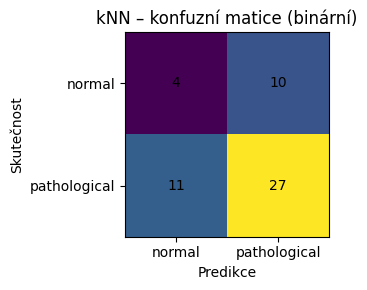

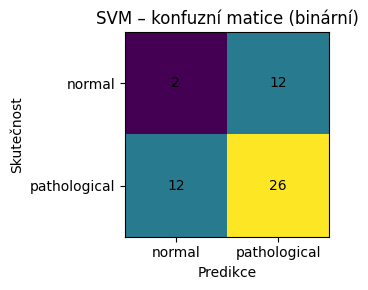

In [28]:

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

def plot_cm(cm, labels, title, fname):
    plt.figure(figsize=(4,3))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xticks(np.arange(len(labels)), labels, rotation=0)
    plt.yticks(np.arange(len(labels)), labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.xlabel("Predikce")
    plt.ylabel("Skutečnost")
    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=200, bbox_inches="tight")
    plt.show()

plot_cm(res_knn["cm"], ["normal","pathological"], "kNN – konfuzní matice (binární)", "fig5_cm_binary_knn.png")
plot_cm(res_svm["cm"], ["normal","pathological"], "SVM – konfuzní matice (binární)", "fig5_cm_binary_svm.png")


## 8) Klasifikace patologií (multitřídní)
Výstupy:
- accuracy, macro F1
- konfuzní matice
- tabulka úspěšnosti pro třídy (classification report)

Pozn.: Pokud je nějaká třída v datech velmi malá, výsledky se mohou zhoršit


In [29]:
def evaluate_multiclass(X, y, model, test_size=0.25):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)

    acc = accuracy_score(yte, pred)
    f1m = f1_score(yte, pred, average="macro")
    labels = sorted(pd.unique(y))
    cm = confusion_matrix(yte, pred, labels=labels)
    rep = classification_report(yte, pred, output_dict=True, zero_division=0)
    return {"acc": acc, "f1_macro": f1m, "cm": cm, "labels": labels, "report": rep}

knn_multi = Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(n_neighbors=7))])
svm_multi = Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", C=10.0, gamma="scale"))])

res_knn_m = evaluate_multiclass(X, y_multi, knn_multi)
res_svm_m = evaluate_multiclass(X, y_multi, svm_multi)

pd.DataFrame([
    {"model":"kNN (k=7)", "acc": res_knn_m["acc"], "f1_macro": res_knn_m["f1_macro"]},
    {"model":"SVM (RBF)", "acc": res_svm_m["acc"], "f1_macro": res_svm_m["f1_macro"]},
])


,model,acc,f1_macro
0,kNN (k=7),0.307692,0.285822
1,SVM (RBF),0.384615,0.390812


## 8.1) Zhodnocení úspěšnosti

- **Binární (normal vs. pathological):**
  - kNN (k=5): accuracy = 0.596, balanced accuracy = 0.498, F1 = 0.720
  - SVM (RBF): accuracy = 0.538, balanced accuracy = 0.414, F1 = 0.684
  - Balanced accuracy je nižší kvůli nevyváženosti tříd (pathological >> normal).

- **Multitřídní (typ patologie):**
  - kNN (k=7): accuracy = 0.308, macro F1 = 0.286
  - SVM (RBF): accuracy = 0.385, macro F1 = 0.391
  - Multitřídní klasifikace je obtížnější – třídy jsou si akusticky podobné a mají různé počty vzorků.


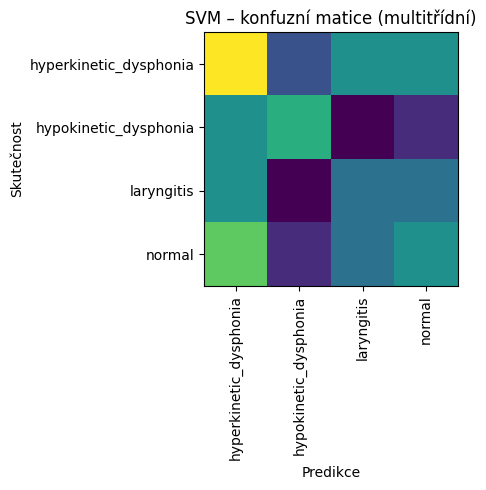

In [30]:

FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

def plot_cm_labels(cm, labels, title, fname):
    plt.figure(figsize=(max(6, 0.35*len(labels)), max(5, 0.35*len(labels))))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.yticks(np.arange(len(labels)), labels)
    plt.xlabel("Predikce")
    plt.ylabel("Skutečnost")
    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=200, bbox_inches="tight")
    plt.show()

plot_cm_labels(res_svm_m["cm"], res_svm_m["labels"], "SVM – konfuzní matice (multitřídní)", "fig6_cm_multiclass_svm.png")


In [31]:
# Tabulka úspěšnosti po třídách (SVM)
rep = res_svm_m["report"]
df_rep = pd.DataFrame(rep).T
df_rep = df_rep.rename(columns={"precision":"PPV", "recall":"Se", "f1-score":"F1"})
df_rep.head(15)


,PPV,Se,F1,support
hyperkinetic_dysphonia,0.363636,0.444444,0.400000,18.000000
hypokinetic_dysphonia,0.625000,0.500000,0.555556,10.000000
laryngitis,0.300000,0.300000,0.300000,10.000000
normal,0.333333,0.285714,0.307692,14.000000
accuracy,0.384615,0.384615,0.384615,0.384615
macro avg,0.405492,0.382540,0.390812,52.000000
weighted avg,0.393502,0.384615,0.385832,52.000000


## 9) Vizualizace klasifikace v prostoru příznaků (PCA)
PCA projekce do 2D pro přehled, jak se třídy oddělují.


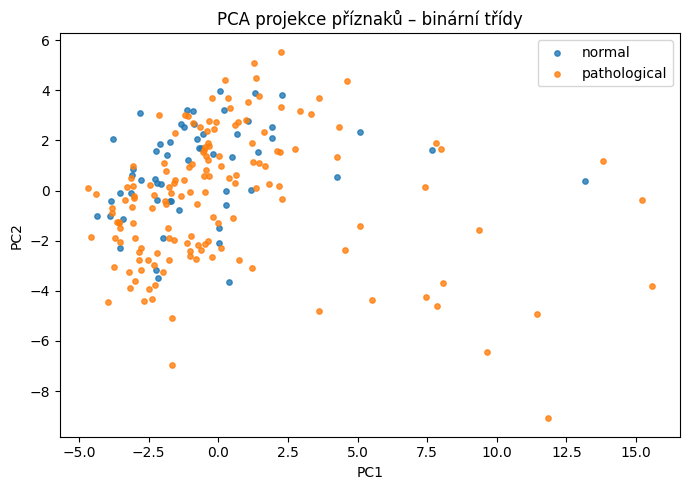

In [ ]:
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(StandardScaler().fit_transform(X))

plt.figure(figsize=(7,5))
classes = sorted(pd.unique(y_bin))
for c in classes:
    mask = (y_bin == c)
    plt.scatter(Xp[mask,0], Xp[mask,1], s=15, label=c, alpha=0.8)
plt.title("PCA projekce příznaků – binární třídy")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "fig4_pca_binary.png", dpi=200, bbox_inches="tight")
plt.show()
